In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


In [3]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,NaN,NaN
1,2010-07-02,18.0,0,0,NaN,NaN
2,2010-07-03,20.0,0,0,NaN,NaN
3,2010-07-04,20.0,0,0,NaN,NaN
4,2010-07-05,14.0,0,0,NaN,NaN


In [4]:
### datimeをdatetime64[ns]型に変更。

In [5]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         2101 non-null   float64
 1   client    2466 non-null   int64  
 2   close     2466 non-null   int64  
 3   price_am  2250 non-null   float64
 4   price_pm  2249 non-null   float64
 5   year      2466 non-null   int64  
 6   month     2466 non-null   int64  
 7   day       2466 non-null   int64  
 8   weekday   2466 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 192.7 KB


In [8]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
#df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)

In [9]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'year', 'month', 'day']


### Pandas Profining

In [10]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

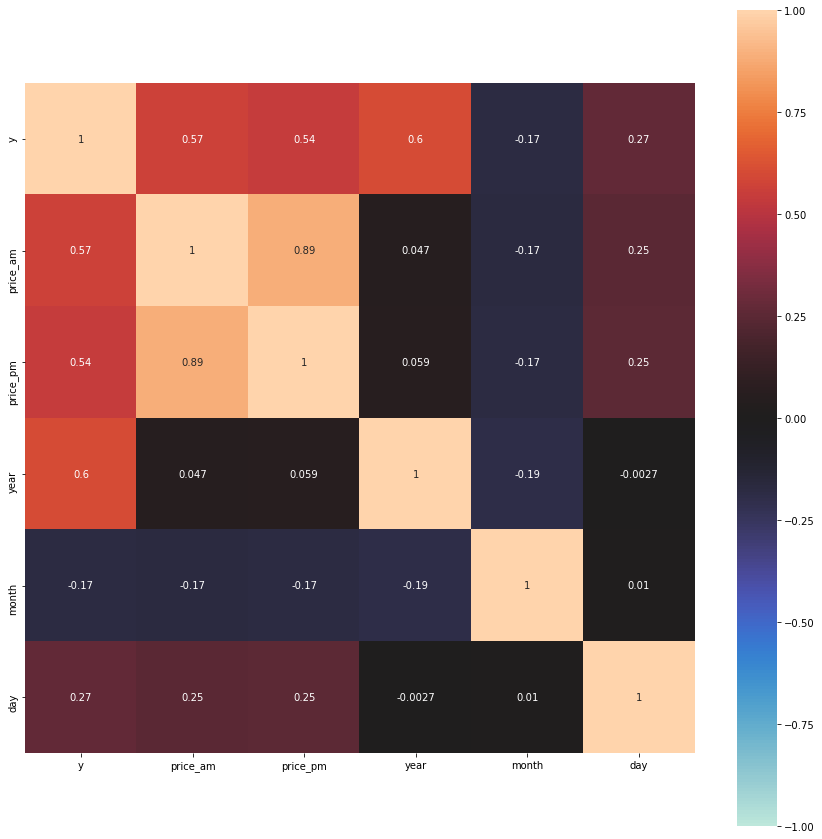

In [11]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


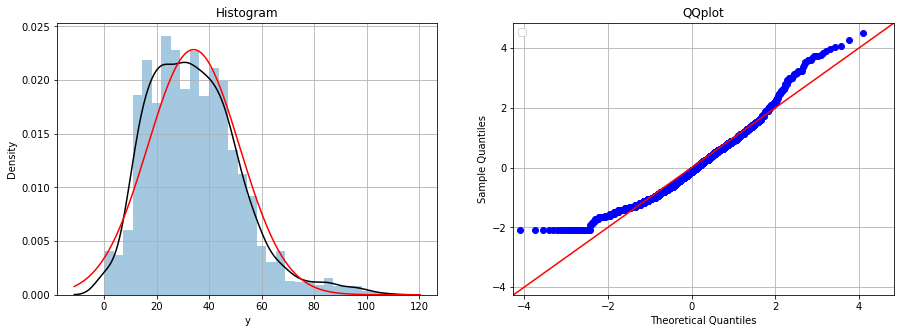

In [12]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Fill nan

In [13]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

#df['price_am'].fillna(df['price_am'].median(), inplace=True)
# df['price_pm'].fillna(df['price_pm'].median(), inplace=True)

### Dummy

In [14]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [15]:
df.head(10)

,y,price_am,price_pm,year,month,day,client_1,close_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,7,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,7,2,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,7,3,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,7,4,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,7,5,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,2010,7,6,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,2010,7,7,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,2010,7,8,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,2010,7,9,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,2010,7,10,0,0,0,0,0,0,1,0


### Separate Data

In [16]:
train = df[:len(train)]
test = df[len(train):]

In [17]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [18]:
### 線形回帰

In [19]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [20]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          2101 non-null   float64
 1   price_am   2466 non-null   float64
 2   price_pm   2466 non-null   float64
 3   year       2466 non-null   int64  
 4   month      2466 non-null   int64  
 5   day        2466 non-null   int64  
 6   client_1   2466 non-null   uint8  
 7   close_1    2466 non-null   uint8  
 8   weekday_1  2466 non-null   uint8  
 9   weekday_2  2466 non-null   uint8  
 10  weekday_3  2466 non-null   uint8  
 11  weekday_4  2466 non-null   uint8  
 12  weekday_5  2466 non-null   uint8  
 13  weekday_6  2466 non-null   uint8  
dtypes: float64(3), int64(3), uint8(8)
memory usage: 154.1 KB


,y,price_am,price_pm,year,month,day,client_1,close_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,7,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,7,2,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,7,3,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,7,4,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,7,5,0,0,0,0,0,0,0,0


In [21]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [ ]:
# SVM

params_grid = [
    {'C': [1, 10, 100], 'kernel':['linear']},
    {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
]
# パラメータチューニング
clf = GridSearchCV(
    estimator = SVC(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
#clf = RandomForestClassifier(max_depth=10, random_state=0)

# フィッテイング
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
svc_tuned = clf.best_estimator_

# 予測値を反映
y_svc_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_svc_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))

print(best_param)
print("Score = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_svc_pred)))
#print(cross_val_score(clf, X_train, y_train, cv=5))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [ ]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

In [ ]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

In [ ]:
y_total_pred = (y_lasso_pred + y_ridge_pred + y_svc_pred)/3

In [ ]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
#plt.scatter(y_train, y_total_pred)


plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_svc_pred)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [ ]:
submit_sample[1] = y_lasso_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [ ]:
submit_sample.head()